# UAS Obstacle Avoidance Integrating Safety Bound with Reinforcement Learning
Author: Jueming Hu, Arizona State University

Email: jueming.hu@asu.edu

This module demonstrates UAS obstacle avoidance with a risk-based safety bound using reinforcement learning. 

The detailed information can be found [here](https://arc.aiaa.org/doi/abs/10.2514/6.2020-1372)

## Code Requirements

This code has been tested under python 3.7

In [2]:
import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys
import pygame
from matplotlib import colors
import matplotlib.pyplot as plt
from collections import defaultdict
from multiPoly_bound import CliffWalkingEnv
from multiPoly_bound import polysize1
from multiPoly_bound import polysize2
from multiPoly_bound import polysize3
from multiPoly_bound import polysize4
import plotting

if "../" not in sys.path:
  sys.path.append("../") 
matplotlib.style.use('ggplot')

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Environment setup

In [ ]:
origin1 = (49, 0)
des=(0, 49)
env = CliffWalkingEnv(origin1, des)

### Reinforcement Learning Algorithm

In [11]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action. Float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn



def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    margin = 1
    w = 10
    trajectories = []
    for i_episode in range(num_episodes):
        epsilon = 1 / (i_episode+1)
        policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
        # Print out which episode
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # One step in the environment
        pp = []
        aa = []
        rr = []
        pp.append(int(np.ravel_multi_index(origin1,(50, 50))))
        rr.append(-4*np.sqrt(2))
        for t in itertools.count():
            # Take a step
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            aa.append(action) 
            next_state, reward, done, _ = env.step(action)
            rr.append(reward)
            pp.append(int(next_state))

            next_position = np.unravel_index(next_state, (50, 50))
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            best_next_action = np.argmax(Q[next_state])    
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta

            if done:
                aa.append(int(0))
                break
                
            state = next_state
        trajectory = []
        trajectory.append([[pp[i], aa[i], rr[i]] for i in range(len(aa))])
        trajectory = np.array(trajectory)
        trajectory = trajectory.reshape(trajectory.shape[1], trajectory.shape[2])
        if i_episode > 2998:
            trajectories.append(trajectory)

    return Q, stats, np.array(trajectories)

### Result Visualization

In [12]:
def trajectory(point, matrix, poly1, poly2, poly3, poly4):
    cmap = colors.ListedColormap(['white', 'red','black'])
    data = np.zeros(matrix)
    for i in range(len(point)):
        ax = plt.gca()
        data[np.unravel_index(point[i], matrix)] = 1
        data[poly1[0]:poly1[1]+1, poly1[2]:poly1[3]+1] = 2
        data[poly2[0]:poly2[1]+1, poly2[2]:poly2[3]+1] = 2
        data[poly3[0]:poly3[1]+1, poly3[2]:poly3[3]+1] = 2
        data[poly4[0]:poly4[1]+1, poly4[2]:poly4[3]+1] = 2

        ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=0.5)
        ax.set_xticks(np.arange(-.5, matrix[0], 1));
        ax.set_yticks(np.arange(-.5, matrix[1], 1));
        ax.grid(True)
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        ax.imshow(data, cmap=cmap)

        #plt.show()
        # ax.figure.savefig('picture_multiPoly_withBound/pic_' + str(i) + '.png')


### Example

Episode 3000/3000.

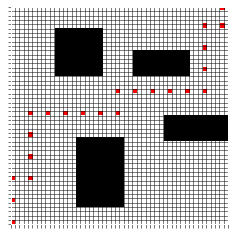

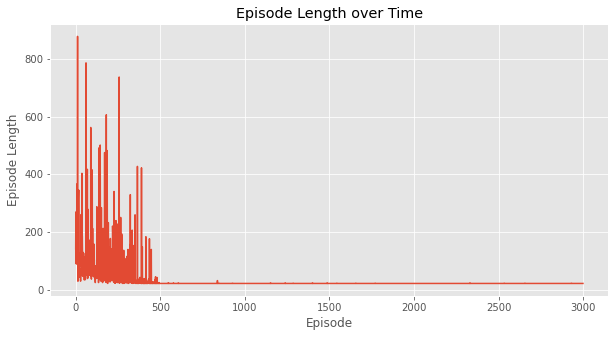

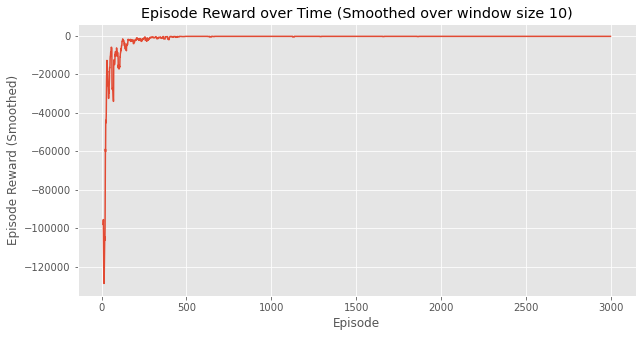

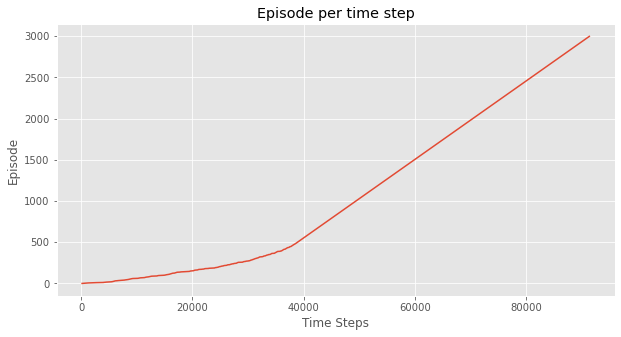

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [13]:
# main 

# train the agent
Q, stats, trajectories = q_learning(env, 3000)

# save the last episode
with open('multiPoly_withbound.txt', 'w') as outfile:
    outfile.write('# Array shape: {0}\n'.format(trajectories.shape))
    for data_slice in trajectories:
        np.savetxt(outfile, data_slice, fmt='%-7.2f')
        outfile.write('# New slice\n')

# trajectory visualization
# show the agent's position at each time step
trajectories = np.loadtxt('multiPoly_withbound.txt')
trajectories = trajectories.astype(int)
trajectories = trajectories.reshape((1, 23, 3))
trajectory(trajectories[0,:,0], (50,50), polysize1, polysize2, polysize3, polysize4)

# RL learning curve 
plotting.plot_episode_stats(stats)